In [ ]:
## Highly similar to RDA_freq_diff.ipynb, except that this time we also port in decorrelation time scales (tau) from
#  RDA_freq_tau.nc, and use those values to change the effective sample size

In [1]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
%matplotlib notebook
import numpy.ma as ma
import scipy.stats as st

In [2]:
## LOAD FROM NETCDF FILE ##
savefile = "RDA_hov_periods"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#populate lists with intensity occupancy plots for each different time period (periods given below)
p1_beg = [1951,1980]
p1_end = [1979,1993]
p2_beg = [1980,1994]
p2_end = [2007,2007]

#in this case, we're just going to load the smoothed plots of hovmoller frequency
lats_1_p1 = []
lats_p1 = []

lats_1_p2 = []
lats_p2 = []


for p1_b, p1_e, p2_b, p2_e in zip(p1_beg, p1_end, p2_beg, p2_end):

    years_p1= str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    print(years_p1)
    years_p2= str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    print(years_p2)
    
    lats_1_p1.append(hovnc['lat_1_hov_smth_' + years_p1][:])
    lats_p1.append(hovnc['lat_hov_smth_' + years_p1][:])
    
    lats_1_p2.append(hovnc['lat_1_hov_smth_' + years_p2][:])
    lats_p2.append(hovnc['lat_hov_smth_' + years_p2][:])
    
hovnc.close()

5179
8007
8093
9407


In [3]:
#returns the standard error for a Bernoulli variable with probability of success p and number
#of trials n.
def bernoulli_std(p, n):
    s = (p*(1-p)/n)**.5
    return s

#performs bernoulli_std for each point in 2D numpy array F, returns array of standard deviations
#F is a probability distributed between 0 and 1.

#ALSO, compared with freq_std in RDA_freq_diff, incorporates decorrelation time scale tau, used to change
#effective sample size N as n/tau, where n is total number of observations.
def freq_std_tau(F, years, dayrange, latrange, tau):
    S = np.zeros(F.shape)
    ll = (latrange-1)/2
    
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            
            #have to adjust number of samples if we're at the edges
            lrange = int(min(S.shape[1]-1,j+ll) - max(0,j-ll) + 1)
            nn = (years*dayrange*lrange)/tau[i,j] ## EFFFECTIVE sample size scaled by autocorrelation tau
            S[i,j] = bernoulli_std(F[i,j],nn)
    
    return S

In [9]:
## LOAD decorrelation timescales from RDA_freq_tau.nc
savefile = "RDA_freq_tau"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
tauname = ferretpath + savefile + ".nc"
taunc = nc.Dataset(tauname, "r")

taus = []
taus.append(taunc['tau_constant'][:])
taus.append(taunc['tau_halfyear'][:])
taus.append(taunc['tau_seasonal'][:])

taunc.close()

In [24]:
## the second argument in freq_std is the number of years in the sample - needs to change
#p1_beg = [1951,1980]
#p1_end = [1979,1993]
#p2_beg = [1980,1994]
#p2_end = [2007,2007]

lats_1_p1_std = []
lats_p1_std = []

lats_1_p2_std = []
lats_p2_std = []

tst = []

for mytau in taus:
    #find standard deviation for each day and bin
    #if the value for tau is NaN for a given time period (in other words, no bands happen), make tau=1
    mytau[np.isnan(mytau)] = 1 
    
    lats_1_p1_std.append([ freq_std_tau(x, ye-yb+1, 15, 5, mytau) for x, yb, ye in zip(lats_1_p1, p1_beg, p1_end) ])
    lats_p1_std.append([ freq_std_tau(x, ye-yb+1, 15, 5, mytau) for x, yb, ye in zip(lats_p1, p1_beg, p1_end) ])

    lats_1_p2_std.append([ freq_std_tau(x, ye-yb+1, 15, 5, mytau) for x, yb, ye in zip(lats_1_p2, p2_beg, p2_end) ])
    lats_p2_std.append([ freq_std_tau(x, ye-yb+1, 15, 5, mytau) for x, yb, ye in zip(lats_p2, p2_beg, p2_end) ])
    
    tst.append([ freq_std_tau(x, ye-yb+1, 15, 5, np.ones([365,22])) for x, yb, ye in zip(lats_p1, p1_beg, p1_end) ])

In [33]:
lats_p1_std[0][0].shape

(365, 22)

<IPython.core.display.Javascript object>


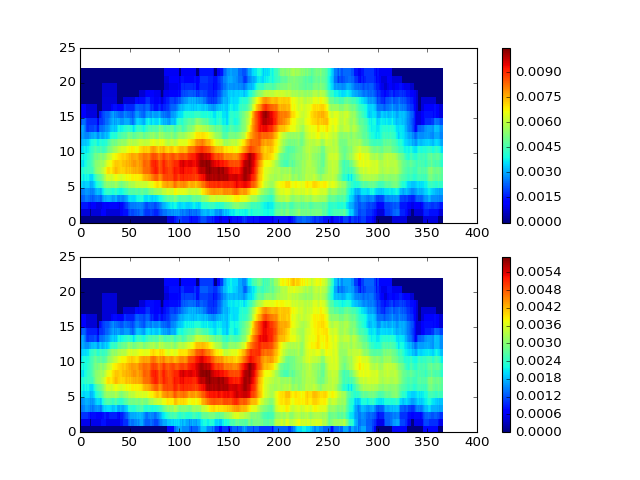

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
plt.pcolormesh(lats_p1_std[0][0].T, vmin=0, vmax=1)
plt.colorbar()

ax2 = fig.add_subplot(2,1,2)
plt.pcolormesh(tst[0][0].T, vmin=0, vmax=1)